In [29]:
import pickle 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
import pickle
from scipy.stats import skew,kurtosis,iqr
from ecg import ecg_feature_computation
import math
from hrvanalysis import remove_ectopic_beats
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

def get_label(user_data,st,et):
    label = 2
    for k in range(user_data.shape[0]):
        if st>=user_data[k,0] and et<=user_data[k,1]:
            label = user_data[k,2]

    return label

def get_features(a):
    features = [len(a)/60,np.median(a),
                len(np.where(a>0)[0])/60,len(np.where(a>.5)[0])/60,
                len(np.where(a>.4)[0])/60,len(np.where(a>.6)[0])/60,
                len(np.where(a>.8)[0])/60,len(np.where(a==0)[0])/60]
    return np.array(features)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_weighted_rr_features(a):
    a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


no_of_feature = 7
# no_of_feature = 2
from scipy.stats import variation
def combine_data_sobc(feature_matrix,user_col,label_col,quality_col,heart_rate_final,label_data):
    try:
        participant = user_col[0]
        feature_matrix = []
        feature_matrix_quality = []
        user_col = []
        label_col = []
        quality_col = []
        heart_rate_final = heart_rate_final[heart_rate_final[:,2]>.05]
        ts_array = np.arange(heart_rate_final[0,0],heart_rate_final[-1,0],60000)
        for t in ts_array:
            index = np.where((heart_rate_final[:,0]>=t-30000)&(heart_rate_final[:,0]<t+30000))[0]
            if len(index)<30:
                continue
            heart_rate_window = heart_rate_final[index]
            if np.median(heart_rate_window[:,2])<.1:
                continue
            label = get_label(label_data,t-20000,t+20000)
            try:
                r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,2]>.25,1],heart_rate_window[heart_rate_window[:,2]>.25,2])
            except:
                continue
            index = np.where((heart_rate_window[:,1]<r+3*tt)&(heart_rate_window[:,1]>r-3*tt))[0]
            heart_rate_window = heart_rate_window[index]
            if len(index)<30:
                continue
#             feature = ecg_feature_computation(heart_rate_window[:,0],
#                                               heart_rate_window[:,1])
            feature = get_weighted_rr_features(heart_rate_window[:,1:])
            feature_quality = get_features(heart_rate_window[:,2])
            feature_matrix.append(np.array(feature).reshape(-1,no_of_feature))
            feature_matrix_quality.append(np.array(feature_quality).reshape(-1,8))
            user_col.append(participant)
            label_col.append(label)
            quality_col.append(np.median(heart_rate_window[:,2]))
        return np.array(feature_matrix).reshape(-1,no_of_feature),user_col,label_col,quality_col,heart_rate_final,np.array(feature_matrix_quality).reshape(-1,8)
    except Exception as e:
        print(e)
        return np.zeros((0,no_of_feature)),[],[],[],[],np.array([])

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done  28 out of  72 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  43 out of  72 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  58 out of  72 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  72 out of  72 | elapsed:    0.7s finished


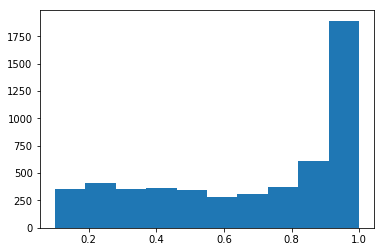

(3253, 7) (3253,) 3253 724 3253 3253 32


In [30]:
final_data = pickle.load(open('/home/jupyter/mullah/Test/data_yield/data/data_sobc_25_secs.p','rb'))
final_output = Parallel(n_jobs=30,verbose=5)(delayed(combine_data_sobc)(*a) for a in final_data)
X = np.zeros((0,no_of_feature))
X_qual = []
y = []
groups = []
qual = []
for m in final_output:
    feature_matrix,user_col,label_col,quality_col,hr,quals = m
    if len(feature_matrix)<2:
        continue
    quals1 = np.sqrt(np.sum(np.square(quals),axis=1)/quals.shape[1])
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[:,i], quals1)
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    tmp = StandardScaler().fit_transform(feature_matrix)
    X = np.concatenate((X,feature_matrix))
    X_qual.extend(list(quals1))
    y.extend(label_col)
    groups.extend(user_col)
    qual.extend(quality_col)

plt.hist(qual)
plt.show()
from sklearn import linear_model
def get_only_stress_no_stress(X,groups,y,qual,X_qual):
    y = np.int64(y)
    index = np.where(y<2)[0]
    X,groups,y,qual,X_qual = X[index,:],groups[index],y[index],qual[index],X_qual[index]
    ind = []
    not_wanted = ['ae1238c0-6146-491b-b199-ead784386c5b',
                 'bb3e2113-ca54-4f36-9ecf-d5fff354521f']
    for grp in np.unique(groups):
        if grp in not_wanted:
            continue
        tmp = np.where(groups==grp)[0]
        if len(np.unique(y[tmp]))>1:
            ind.extend(list(tmp))
    ind = np.int64(np.array(ind))
    return X[ind],y[ind],groups[ind],qual[ind],X_qual[ind]
y = np.array(y)
groups = np.array(groups)
X_qual = np.array(X_qual)
y = y[~np.isnan(X).any(axis=1)]
groups = groups[~np.isnan(X).any(axis=1)]
X_qual = X_qual[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]

y = y[~np.isinf(X).any(axis=1)]
qual = np.array(qual)
qual = qual[~np.isinf(X).any(axis=1)]
groups = groups[~np.isinf(X).any(axis=1)]
X = X[~np.isinf(X).any(axis=1)]
X_qual = X_qual[~np.isinf(X).any(axis=1)]

X,y,groups,qual,X_qual = get_only_stress_no_stress(X,groups,y,qual,X_qual)
print(X.shape,X_qual.shape,len(y),len(y[y==1]),len(groups),len(qual),len(np.unique(groups)))

In [31]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
delta = 0.1

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

paramGrid = {'svc__kernel': ['rbf'],
             'svc__C': [11,100,1000],
             'svc__gamma': [np.power(2,np.float(x)) for x in np.arange(-8, -2, .5)],
             'svc__class_weight': [{0: w, 1: 1 - w} for w in [.2,.265,.3,.35]],
             'svc__probability':[False]
}
pca = PCA(n_components=4)
clf = Pipeline([('svc', SVC())])
# clf = make_pipeline(SMOTE(),SVC())
# clf = SVC()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='accuracy',verbose=5)
grid_search.fit(X[:,:],y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Fitting 32 folds for each of 144 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 2946 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4512 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 |

Best parameter (CV score=0.856):
{'svc__C': 1000, 'svc__class_weight': {0: 0.35, 1: 0.65}, 'svc__gamma': 0.015625, 'svc__kernel': 'rbf', 'svc__probability': False}


In [32]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20)
print(confusion_matrix(y,y_pred),classification_report(y,y_pred))

[[2339  190]
 [ 277  447]]               precision    recall  f1-score   support

           0       0.89      0.92      0.91      2529
           1       0.70      0.62      0.66       724

   micro avg       0.86      0.86      0.86      3253
   macro avg       0.80      0.77      0.78      3253
weighted avg       0.85      0.86      0.85      3253



In [13]:
clf.fit(X,y)
pickle.dump(clf,open('../models/stress.p','wb'))

In [33]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba')[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator, param_grid, scoring, fit_params, n_jobs, iid,
                refit, cv, verbose, pre_dispatch, error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))

        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

In [35]:
gkf = GroupKFold(n_splits=len(np.unique(groups)))
# X1 = preprocessing.StandardScaler().fit_transform(X)
delta = 0.1
parameters1 = {'kernel': ['rbf'],
              'C': [11,1000],
              'gamma': [np.power(2,np.float(x)) for x in np.arange(-8, -2, .5)],
              'class_weight': [{0: w, 1: 1 - w} for w in [.25,.265,.26,.35]],
              'probability':[True],
              'verbose':[False],
              'cache_size':[2000]}
parameters = {
    'min_samples_leaf': [4],
    'max_features': [.7,1],
    'n_estimators': [100,200,300],
    'n_jobs': [-1],
    'criterion':['gini','entropy'],
    'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
    'random_state': [42]
       }
svc = SVC()
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters1, cv=list(gkf.split(X,y,groups=groups)),\
                                   n_jobs=20, scoring=f1Bias_scorer_CV, verbose=5, iid=False)
grid_search.fit(X,y)
clf = grid_search.best_estimator_
clf

Fitting 32 folds for each of 96 candidates, totalling 3072 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done  77 out of  96 | elapsed:  6.0min remaining:  1.5min
[Parallel(n_jobs=20)]: Done  96 out of  96 | elapsed:  9.7min finished


SVC(C=11, cache_size=2000, class_weight={0: 0.25, 1: 0.75}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0078125, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
clf.probability = True
CV_probs = cross_val_probs(clf, X, y, gkf.split(X,y,groups=groups))
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))
# for grp in np.unique(groups):
#     index = np.where(groups==grp)[0]
#     print(Counter(y[index])[1]/Counter(y[index])[0],grp)

0.6693069306930693 0.2635087386250891
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2529
           1       0.64      0.70      0.67       724

   micro avg       0.85      0.85      0.85      3253
   macro avg       0.78      0.79      0.78      3253
weighted avg       0.85      0.85      0.85      3253

[[2245  284]
 [ 217  507]]
0.6274509803921569


In [37]:
clf.fit(X,y)
pickle.dump(clf,open('../models/stress_model_weighted.p','wb'))